In [1]:
%matplotlib inline
from shapely.geometry import asShape
import numpy as np
import matplotlib.pyplot as plt
import pycno
import PseudoNetCDF as pnc
from osgeo import ogr, osr
import pandas as pd
from collections import OrderedDict

ogr.UseExceptions()

In [3]:
shppath = '/work/ROMO/gis_rasters/NaturalEarth/shapefiles/ne_10m_admin_1_states_provinces.shp'
grdpath = '/home/bhenders/GRIDDESC'
gdnam = '12US2'

In [4]:
gf = pnc.pncopen(grdpath, format='griddesc', GDNAM=gdnam)
lons, lats = gf.ij2ll(*np.meshgrid(np.arange(gf.NCOLS), np.arange(gf.NROWS)))
statef = ogr.Open('/work/ROMO/gis_rasters/NaturalEarth/shapefiles/ne_10m_admin_1_states_provinces.shp')

In [5]:
lcc_sref = osr.SpatialReference()
proj4str = gf.getproj(withgrid=False, projformat='proj4')
lcc_sref.ImportFromProj4(proj4str)
print(lcc_sref.ExportToProj4())

layer = statef.GetLayer(0)
layer_sref = layer.GetSpatialRef()
print(layer_sref.ExportToProj4())
layer2lcc = osr.CoordinateTransformation(layer_sref, lcc_sref)

nfeats = layer.GetFeatureCount()
usstates = OrderedDict()

for fi in range(nfeats):
    feat = layer.GetFeature(fi)
    code_hasc = feat['code_hasc']
    if code_hasc.startswith('US.') and code_hasc not in ('US.AK', 'US.HI'):
        geom = feat.GetGeometryRef()
        geom.Transform(layer2lcc)
        usstates[code_hasc] = feat


+proj=lcc +lat_1=33 +lat_2=45 +lat_0=40 +lon_0=-97 +x_0=2412000 +y_0=1620000 +a=6370000 +b=6370000 +units=m +no_defs 
+proj=longlat +datum=WGS84 +no_defs 


In [6]:
nfeats, len(usstates)

(4594, 50)

In [7]:
def distfromhasc(lons, lats, hasc):
    distances = lons * np.nan
    # statef = ogr.Open('/work/ROMO/gis_rasters/NaturalEarth/shapefiles/ne_10m_admin_1_states_provinces.shp')
    # sql = f"SELECT code_hasc FROM ne_10m_admin_1_states_provinces WHERE code_hasc = '{hasc}'"
    # layer = statef.ExecuteSQL(sql)
    # feat = layer.GetNextFeature()
    # geom = feat.GetGeometryRef()
    # feat['code_hasc']
    feat = usstates[hasc]
    geom = feat.GetGeometryRef()
    
    for j in np.arange(gf.NROWS):
        y = (j + 0.5) * gf.YCELL
        print(j, end='.', flush=True)
        for i in np.arange(gf.NCOLS):
            x = (i + 0.5) * gf.XCELL
            # x = lons[j, i]
            # y = lats[j, i]
            pt = ogr.Geometry(ogr.wkbPoint)
            pt.AddPoint(x, y)
            # pt.Transform(layer2lcc)
            distances[j, i] = pt.Distance(geom)
    return distances

In [8]:
hascs = sorted(list(usstates))

In [9]:
distances = {}
vals = {}

In [10]:
for hasc in hascs:
    print(f'\n{hasc}', end=':', flush=True)
    if hasc not in distances:
        distances[hasc] = distfromhasc(lons, lats, hasc)


US.AL:0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.
US.AR:0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40

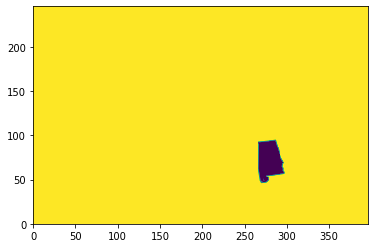

In [16]:
plt.pcolormesh(distances['US.AL'], vmax=20e3)

In [28]:
outf = gf.subset([])
delattr(outf, 'Conventions')
del outf.dimensions['nv']
for hasc in list(distances):
    outkey = hasc.replace('.', '_')
    outv = outf.copyVariable(gf.variables['DUMMY'], key=outkey)
    outv.units = 'm'
    outv.long_desc = f'{hasc}'
    outv.var_desc = f'Distance in m from HASC Code: {hasc} to cell center'
    outv[:] = distances[hasc]

In [29]:
delattr(outf, 'VAR-LIST')
outf.SDATE = 1970001
outf.TSTEP = 10000
outf.updatemeta()
outf.updatetflag(overwrite=True)
outf.variables['TFLAG'][:, :, 0] = 0
outf.SDATE = -635
outf.TSTEP = 0
outf.variables.move_to_end('TFLAG', last=False)
outf.FILEDESC = """Distance to US States based on Natural Earther 10e6:1 resolution shapefile""".ljust(4800)
outf.HISTORY = "Created using NaturalEarth_for_CMAQ_Distance.ipynb".ljust(4800)

In [30]:
outf.save(f'output/ne_10m_admin_1_states_provinces_distance_to_US_States.{gdnam}.nc', format='NETCDF3_CLASSIC').close()

Adding dimensions
Adding globals
Adding variables
Defining TFLAG
Defining US_AL
Defining US_AR
Defining US_AZ
Defining US_CA
Defining US_CO
Defining US_CT
Defining US_DC
Defining US_DE
Defining US_FL
Defining US_GA
Defining US_IA
Defining US_ID
Defining US_IL
Defining US_IN
Defining US_KS
Defining US_KY
Defining US_LA
Defining US_MA
Defining US_MD
Defining US_ME
Defining US_MI
Defining US_MN
Defining US_MO
Defining US_MS
Defining US_MT
Defining US_NC
Defining US_ND
Defining US_NE
Defining US_NH
Defining US_NJ
Defining US_NM
Defining US_NV
Defining US_NY
Defining US_OH
Defining US_OK
Defining US_OR
Defining US_PA
Defining US_RI
Defining US_SC
Defining US_SD
Defining US_TN
Defining US_TX
Defining US_UT
Defining US_VA
Defining US_VT
Defining US_WA
Defining US_WI
Defining US_WV
Defining US_WY
Populating TFLAG
Populating US_AL
Populating US_AR
Populating US_AZ
Populating US_CA
Populating US_CO
Populating US_CT
Populating US_DC
Populating US_DE
Populating US_FL
Populating US_GA
Populating US